In [1]:
import fsspec
import scvi
import scanpy as sc
import h5py
import anndata
import pandas as pd
import network
import numpy as np
import networkx
import desc 
import matplotlib
import matplotlib.pyplot as plt
import umap
import scvelo as scv
import h5py
import collections
import anndata
import igraph
import networkx
import seaborn as sns
%load_ext rpy2.ipython
%matplotlib inline 
%load_ext rpy2.ipython
sc.settings.verbosity = 3     
sc.set_figure_params(figsize=(4, 4))
np.random.seed(42)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument i

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS384-OS384.h5ad


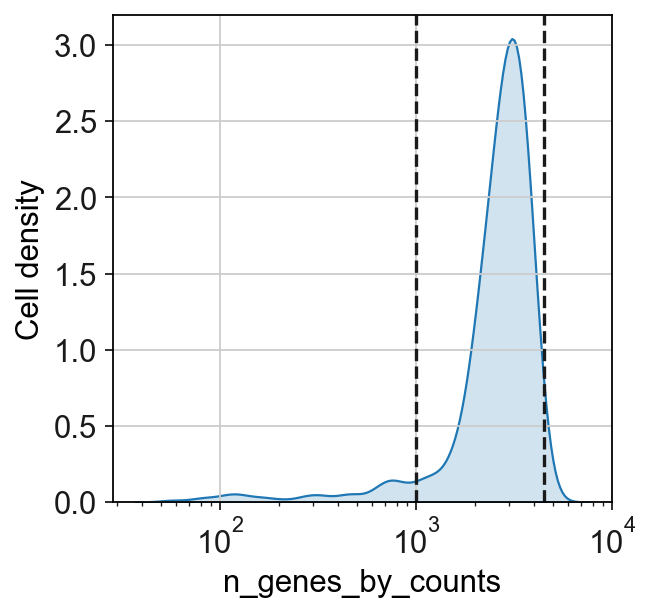

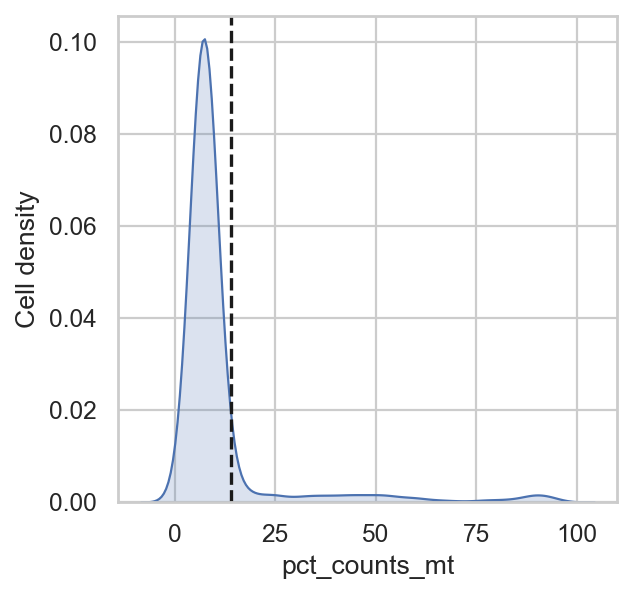

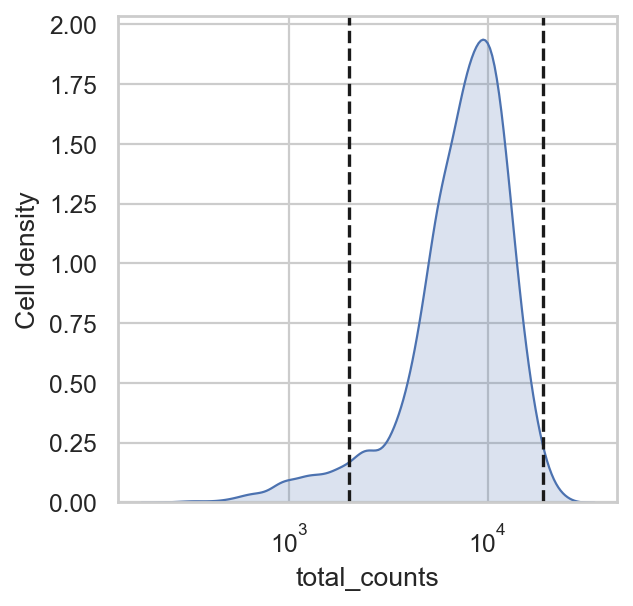

In [2]:
# Reading in OS384 loom file
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS384/OS384.loom', cache = True)

# Ensuring that all variable names are unique
adata.var_names_make_unique()

# Making the var names unique
adata.var_names_make_unique()

# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

## Filtering based on number of genes that have at least 1 count
plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=4500, color='k', linestyle='--')
plt.axvline(x=1000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Filtering based on total counts

plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=2000, color='k', linestyle='--')
plt.axvline(x=19000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

In [3]:
# Filtering the dataset
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

Filtered out 53345 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


97
62
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    416 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    531 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [2]:

# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS384:').rstrip('x'))


# reading in the cell IDs
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/cellID_obs_384.csv")


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,sample_obs["x"])]


# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/percent.mt.csv")


# filtering genes
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)


# normalizing the counts
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)


# log normalizing the data
sc.pp.log1p(adata)
#adata.raw = adata # freeze the state in `.raw`


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3500, # try 3k or 4k
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# concatenating the umap embeddings and the cluster identity
objs = [sample_obs, ccdifference]


# concatenating the ccdifference and sample observations
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 1)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {2:'ccdifference'})

# concatenating the umap embeddings and the cluster identity
objs = [ccdif, percent_mt]
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 2)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {1:'ccdifference'})

# renaming the Cell ID column
ccdif = ccdif.rename(columns = {3:'percent.mt'})

# ordering the umap object based on the sample index
ccdif_ordered = sample_one_index.merge(ccdif, on = "CellID")


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif["CellID"])]


# filtering the adata object based on the seurat sample observations
ccdif_ordered = ccdif_ordered[np.isin(ccdif_ordered["CellID"], adata.obs.index)]


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif_ordered["CellID"])]


# setting the index to CellID 
ccdif_ordered = ccdif_ordered.set_index('CellID')



ccdif_values = ccdif_ordered['ccdifference']



adata.obs['ccdifference'] = ccdif_values.values

# assigning the cluster ids to the adata object
adata.obs['ccdifference'] = ccdif_ordered['ccdifference']

# adding percent mt reads to the adata object
adata.obs['percent.mt'] = ccdif_ordered['percent.mt']

... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS384-OS384.h5ad
filtered out 41460 genes that are detected in less than 3 counts
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [5]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.6)

# making the var names unique
adata.var_names_make_unique()

genes = adata.var.index.values

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


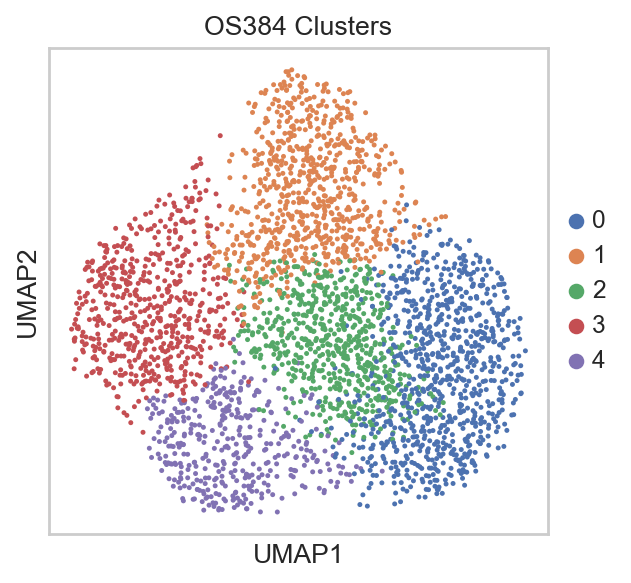

In [6]:
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 Clusters",
    size = 20
)

In [4]:
# setting up the anndata object to include categorical and continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)

In [6]:
# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:53<00:00,  2.36it/s, loss=958, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:53<00:00,  2.31it/s, loss=958, v_num=1]


In [2]:
# reading in the adata file from the data integration script
adata = scvi.read("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# saving my model
model.save("OS384_scvi_model/")

# loading the model
#model = scvi.model.SCVI.load("OS384_scvi_model/", adata, use_gpu=False)

NameError: name 'scvi' is not defined

In [6]:
# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()

# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)


NameError: name 'model' is not defined

In [7]:

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

NameError: name 'sns' is not defined

running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


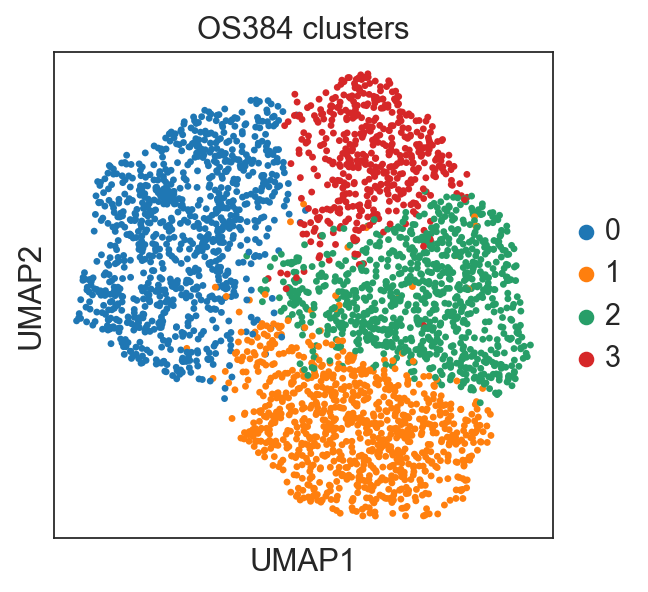

In [23]:
# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True,
    title = 'OS384 clusters'#,
    #save = "OS384_LT_umap.svg"
)

In [19]:
# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

In [ ]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# scoring cell cycle

In [ ]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'leiden_scVI', rotation=45)

# Marker identification with PCA dim reduction

In [16]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(30)
cluster_markers

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,0,1,2,3,4
0,UBE2C,COL1A1,PTTG1,RPS4X,LINC02154
1,AURKB,COL1A2,HSP90AB1,LINC02154,RPS4X
2,CDK1,COL6A3,JPT1,AGBL1,COL8A1
3,TOP2A,PHGDH,VIM,COL8A1,CSAG1
4,TUBB,ITGA11,UBE2S,CSAG1,GMNN
5,HMGB2,ARL4C,CDKN3,STMN2,HMGB2
6,KPNA2,NEAT1,MT2A,FTH1,STMN2
7,UBE2T,TRIB3,H2AZ1,KRT8,FABP4
8,DIAPH3,HLA-A,TUBA1B,HAPLN1,UBE2T
9,CENPK,SQSTM1,HSPD1,TMSB4X,CDK1


In [27]:
Subtype_A_genes_384 = cluster_markers.iloc[:, 1].tolist()

In [28]:
Subtype_A_genes_384

['COL1A1',
 'COL1A2',
 'COL6A3',
 'PHGDH',
 'ITGA11',
 'ARL4C',
 'NEAT1',
 'TRIB3',
 'HLA-A',
 'SQSTM1',
 'EPRS1',
 'HTRA1',
 'PSAT1',
 'COL5A1',
 'GARS1',
 'GAS5',
 'LGALS3',
 'SLC7A11',
 'UNC5B',
 'IFI16',
 'CXXC5',
 'FN1',
 'VEGFA',
 'KDM6B',
 'ATF4',
 'GDF15',
 'CADM1',
 'COL6A2',
 'EIF4EBP1',
 'S100A6']

# Characterizing Clusters

In [ ]:
# performing dgea between two cell types
de_df = model.differential_expression(
    group1="3",
    group2="1",
    groupby="leiden_scVI"
)

de_df.head(20)

In [ ]:
# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)



In [ ]:
# identifying the top marklers within each cluster
markers = {}


cats = adata.obs.leiden_scVI.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0.6]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]

In [ ]:
de_df[de_df.group1 == '3']

In [24]:
subtype_A_markers = {key: markers[key] for key in ['3'] if key in markers}

In [25]:
subtype_A_markers_384 = sum(subtype_A_markers.values(), [])

In [26]:
subtype_A_markers_384

['SFRP2',
 'GDF15',
 'TRIB3',
 'FBXO32',
 'SCX',
 'SLFN5',
 'KIF26B',
 'COL8A2',
 'COL15A1',
 'ARHGAP28',
 'UNC5B',
 'FAM20C',
 'NKAIN4',
 'CCN4',
 'PNRC1',
 'CHAC1',
 'H1-9P',
 'HTRA1',
 'PTX3',
 'CD24',
 'MXRA5',
 'ARMC9',
 'SESN2',
 'COL6A3',
 'PODNL1',
 'IL6',
 'PDE5A',
 'RUNX1T1',
 'KLF4',
 'PTPN13']

In [27]:
df = pd.read_csv("/Users/brendamelano/Desktop/subtype_A_markers.csv", delimiter=",")

In [28]:
OS742_subtype_A_markers = pd.concat([df[col].dropna() for col in df]).tolist()

In [32]:
OS742_subtype_A_markers

{'ABRACL',
 'ACAT2',
 'ACKR3',
 'ALCAM',
 'AOC3',
 'C1QTNF1',
 'CCN2',
 'CCN5',
 'CDKN1A',
 'CDO1',
 'CEMIP',
 'CFD',
 'CNTFR',
 'CSPG4',
 'CSRP2',
 'DOCK4',
 'ECHDC1',
 'ENSG00000287853',
 'FAM43A',
 'GPNMB',
 'GZMK',
 'HSPB3',
 'IGFL2',
 'LGALS3',
 'LGI4',
 'LINC02596',
 'LNCAROD',
 'LRP4',
 'MAMDC2',
 'MATN2',
 'MMP11',
 'MTSS1',
 'NEURL3',
 'OMD',
 'P3H2',
 'PANX3',
 'PGF',
 'PTPRZ1',
 'QPCT',
 'RARRES1',
 'SCUBE3',
 'SELENOM',
 'SGK1',
 'SLC12A8',
 'SNORC',
 'SOD2',
 'SPOCD1',
 'STON2',
 'TBC1D16',
 'THEM5'}

In [29]:
OS742_subtype_A_markers = set(OS742_subtype_A_markers)
subtype_A_markers_384 = set(subtype_A_markers_384)

In [30]:
# Find the intersection (overlap) of the two sets
overlap_genes = OS742_subtype_A_markers.intersection(subtype_A_markers_384)

# Convert the intersection back to a list if you need to
overlap_genes_list = list(overlap_genes)

In [31]:
overlap_genes_list

[]

In [ ]:
# plotting dotplot
sc.pl.dotplot(
    adata,
    markers,
    groupby='leiden_scVI',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

In [ ]:
# heatmap
sc.pl.heatmap(
    adata_filtered, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.31it/s]
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_leiden_scVI']`


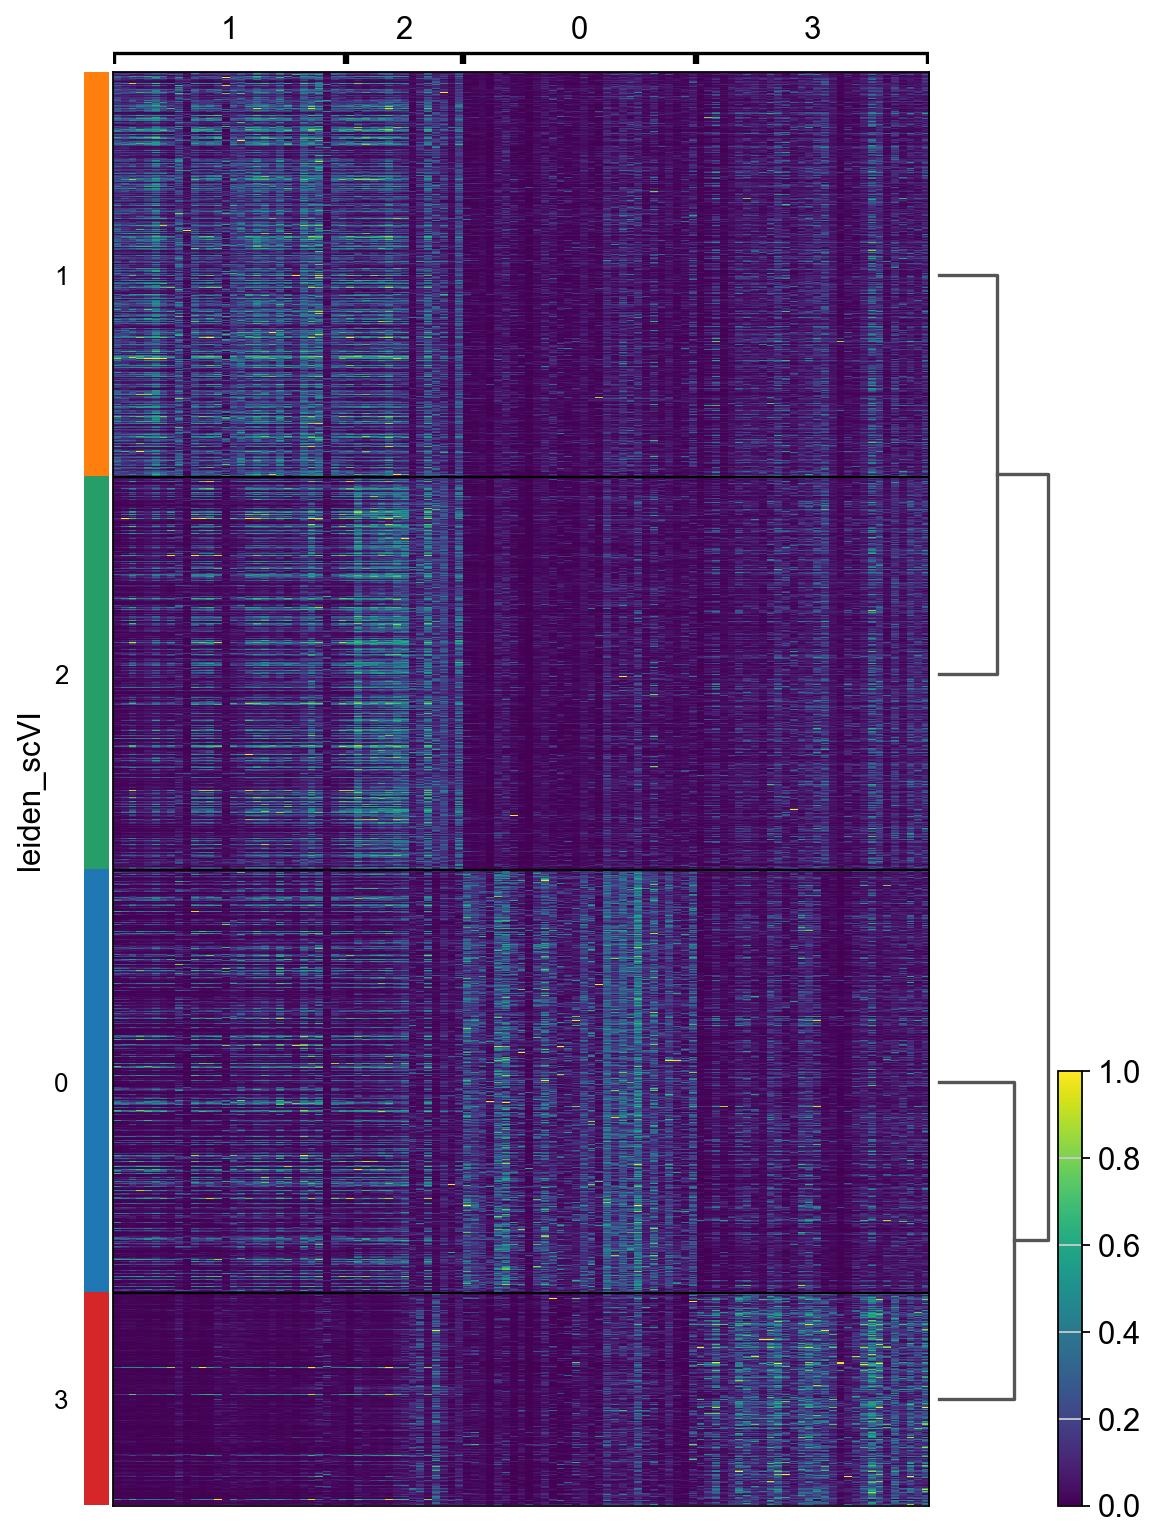

In [14]:
# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)

# identifying the top marklers within each cluster
markers = {}

cats = adata.obs.leiden_scVI.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > .9]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.15] # originall.1

    markers[c] = cell_type_df.index.tolist()[:30]
    
    adata.var_names_make_unique()

# heatmap
sc.pl.heatmap(
    adata, 
    markers, 
    groupby='leiden_scVI', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

# Computing Angiogenic Score

In [7]:
adata.var_names_make_unique() 

In [7]:
angiogenic_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/angiogenic_markers.csv')]
angiogenic_genes_set = set(angiogenic_genes)
missing_genes = angiogenic_genes_set - set(adata.var_names)

print(f"Genes in the list not found in adata.var_names: {missing_genes}")


Genes in the list not found in adata.var_names: {'ASNS', 'EPB41L4A-AS1', 'CEBPB', 'TTC3', 'CTSD', 'SARS', 'GARS', 'B2M', 'ITM2B', 'NARS', 'C6orf48', 'NUPR1'}


In [7]:
angiogenic_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/angiogenic_markers.csv')]
angiogenic_genes = list(set(angiogenic_genes))  # Remove duplicates


In [8]:
# Keep only those genes that are present in adata.var_names
angiogenic_genes = [gene for gene in angiogenic_genes if gene in adata.var_names]


computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    248 total control genes are used. (0:00:00)


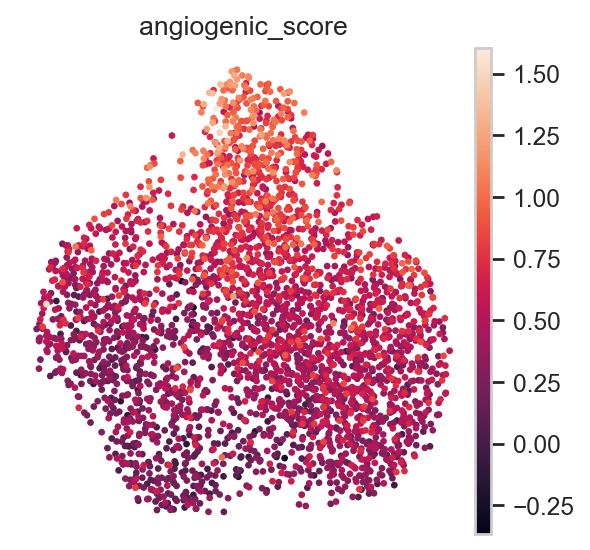

In [8]:



sc.tl.score_genes(adata, angiogenic_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.umap(
    adata,
    color=["angiogenic_score"],
    frameon=False,
)


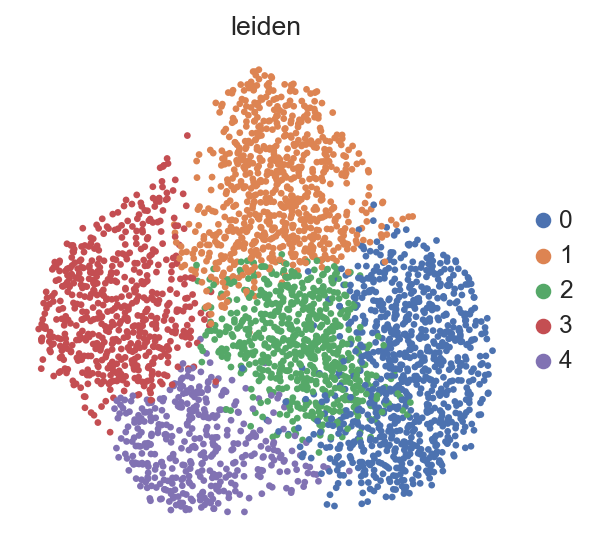

In [9]:

# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
)

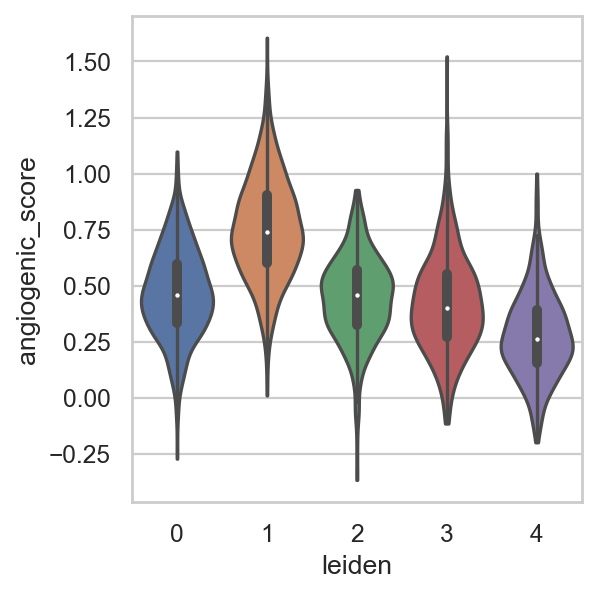

In [10]:
sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box')

In [16]:
adata.var_names_make_unique()

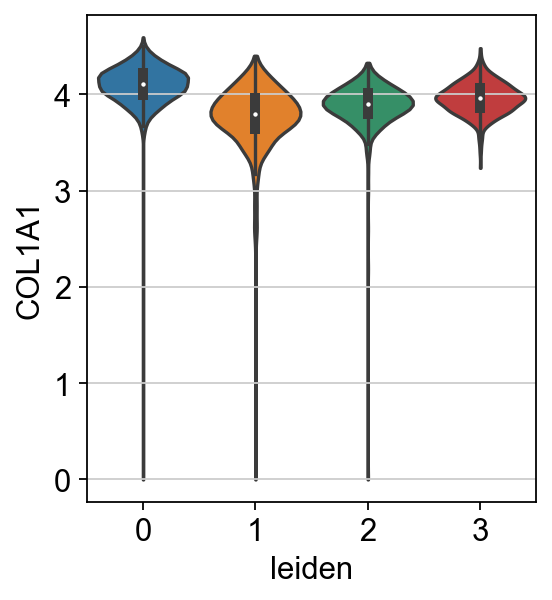

In [14]:
sc.pl.violin(adata, 'COL1A1', groupby='leiden', stripplot=False, inner='box')

# immune modulating score

computing score 'ImmuneModulating_score'
    finished: added
    'ImmuneModulating_score', score of gene set (adata.obs).
    240 total control genes are used. (0:00:00)


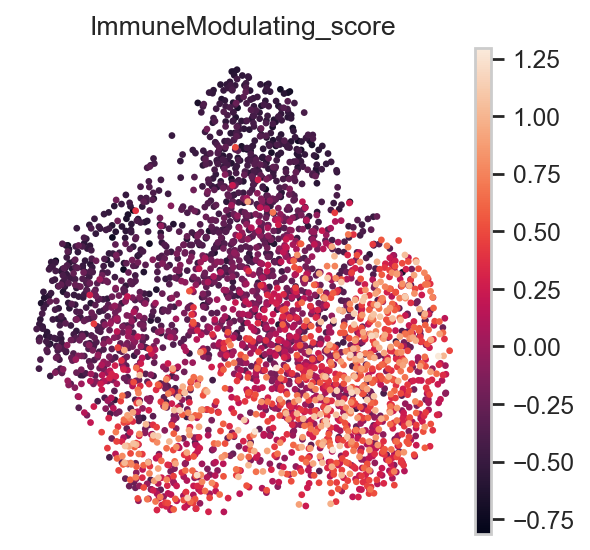

In [11]:
# reading in gene lists for gsea
ImmuneModulating_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/immune_modulating_genes.csv')]
adata.var_names_make_unique()

sc.tl.score_genes(adata, ImmuneModulating_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='ImmuneModulating_score', random_state=0, copy=False, use_raw=None)

sc.pl.umap(
    adata,
    color=["ImmuneModulating_score"],
    frameon=False,
)

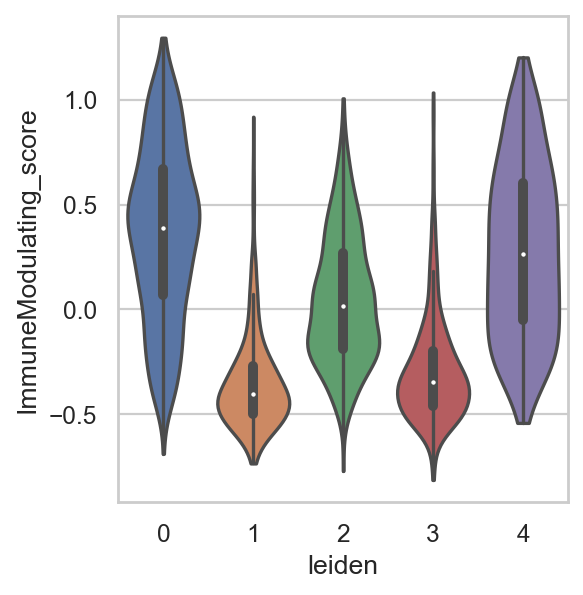

In [12]:
sc.pl.violin(adata, ['ImmuneModulating_score'], groupby='leiden', stripplot=False, inner='box')

In [10]:
# converting the cluster to category type
adata.obs['leiden_scVI'] = adata.obs['leiden_scVI'].astype('category')

adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='2']='3'




# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'esc': ['1'], 'immuneModulating': ['0'], 'angiogenic': ['3']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'subtype'] = i


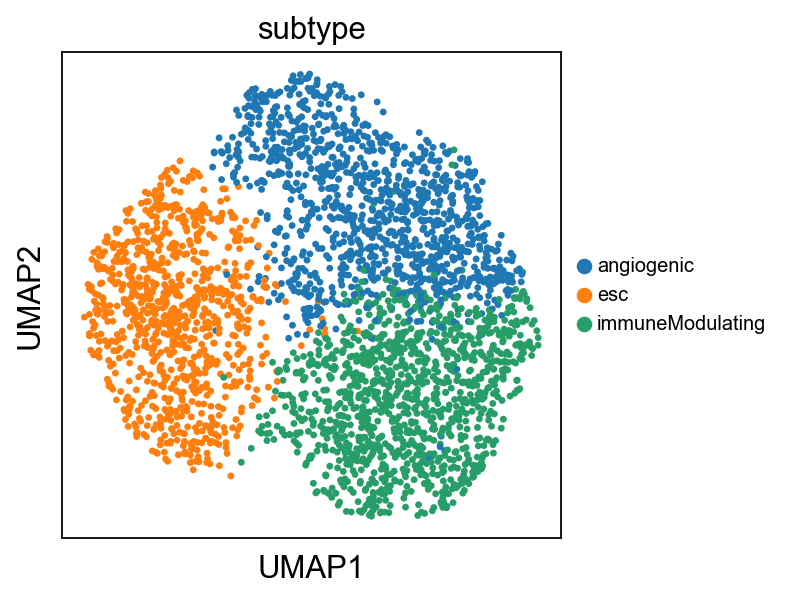

In [11]:
sc.pl.umap(adata, color=['subtype'], legend_fontsize=9)

In [12]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata_subtypes.h5ad")

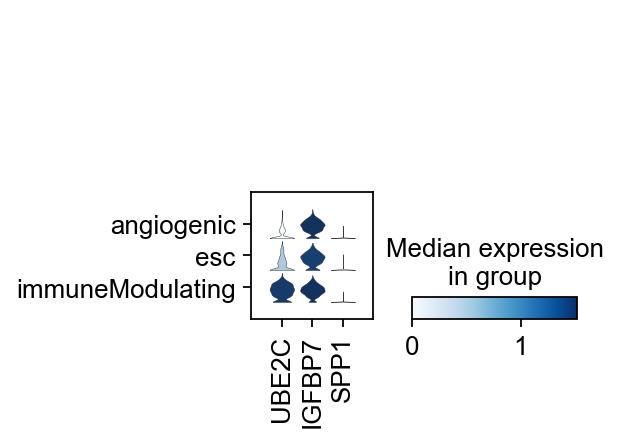

In [16]:
sc.pl.stacked_violin(adata, ["UBE2C", "IGFBP7", "SPP1"], groupby = 'subtype')

# Subtype C Module Enrichment

computing score 'esc_genes'
    finished: added
    'esc_genes', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)


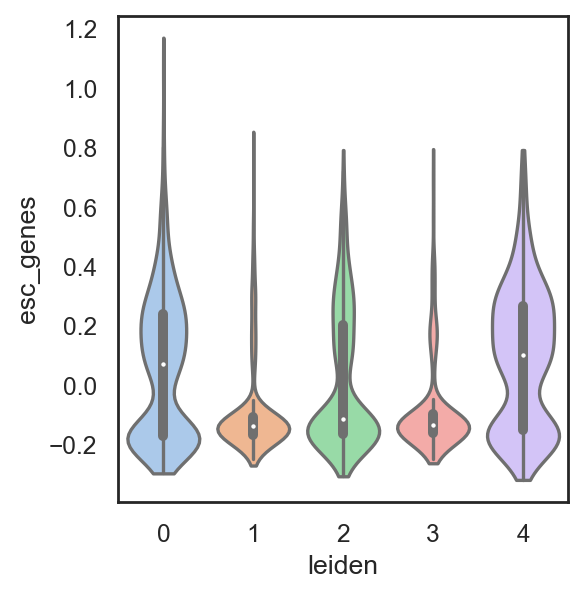

In [15]:
# reading in gene lists for gsea
esc_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/esc_markers.csv')]


esc_genes

# computing gsea
sc.tl.score_genes(adata, esc_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='esc_genes', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['esc_genes'], groupby='leiden', stripplot=False, inner='box')



# RNA velocity with scVelo

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/404 [00:00<?, ?gene/s]

    finished (0:02:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3244 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


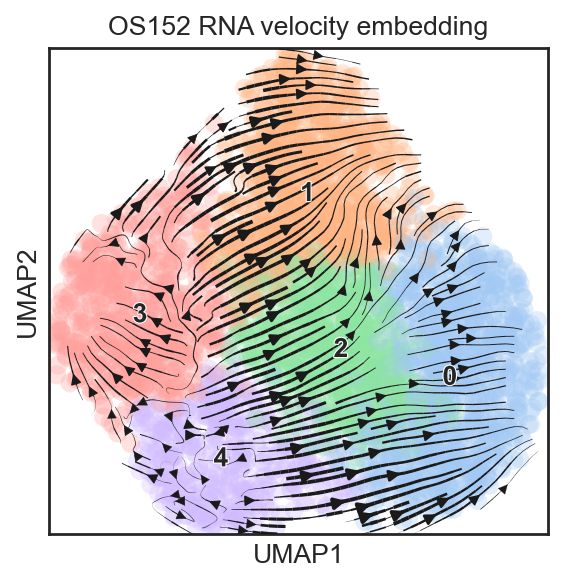

In [13]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)

# Label subtypes

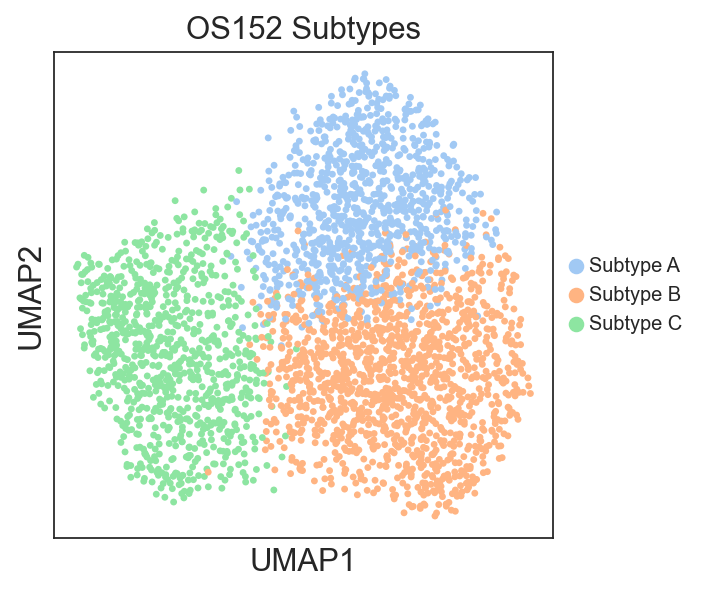

In [25]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='4']='0'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['1'],  'Subtype B': ['0'], 'Subtype C':['0']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


# Create a dictionary that maps each cluster ID to a color from the palette
subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]


sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS384 Subtypes", palette = subtype_colors)

In [26]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/OS384_adata_labeled.h5ad")